## 06: Integrating Census Geographies (OA, LSOA, MSOA)

**Goal:** To enrich point data with valuable demographic context by joining it to official statistical geographies. A common task in spatial analysis is to understand the characteristics of the area surrounding a point of interest.

This notebook demonstrates how to:
1.  Load UK census geographies (we'll use Lower Layer Super Output Areas - LSOAs for Exeter).
2.  Load a corresponding demographic dataset (e.g., population estimates).
3.  Perform a **spatial join** to link a set of points (e.g., our libraries from notebook 04) to the census polygons they fall within.
4.  Analyze the demographic characteristics of the areas served by each library.

### 1. Setup and Library Imports

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import requests
import zipfile
import io

### 2. Download and Load Data

We need two types of data:
* **Geographic Data:** Shapefiles for the LSOAs in Devon.
* **Attribute Data:** A CSV file with population data for each LSOA.

We will download this data directly from the web.

In [4]:
# URL for 2021 LSOA boundaries for England and Wales
lsoa_url = 'https://geoportal.statistics.gov.uk/datasets/ons::lsoa-2021-boundaries-full-clipped-ew-bfc/explore?location=51.000000%2C-2.500000%2C7.00&showTable=true'
# This is an example URL, in a real case you would find the direct download link for the shapefile zip.
# For this notebook, we'll assume the files are in a local 'data' directory.

# Let's create dummy data for demonstration purposes as direct download links are unstable.
try:
    # Attempt to load real data if present
    lsoa_gdf = gpd.read_file('data/LSOA_2021_Boundaries_Full_Clipped.shp')
    pop_df = pd.read_csv('data/lsoa_population_2021.csv')
except Exception:
    print("Could not load local data. Using a placeholder GeoDataFrame for Exeter.")
    from shapely.geometry import box
    # Create a grid to represent LSOAs over Exeter
    xmin, ymin, xmax, ymax = -3.58, 50.68, -3.42, 50.78 # Bounding box for Exeter
    grid_cells = []
    lsoa_codes = []
    for i, x in enumerate(np.linspace(xmin, xmax, 10)):
        for j, y in enumerate(np.linspace(ymin, ymax, 10)):
            grid_cells.append(box(x, y, x + (xmax-xmin)/10, y + (ymax-ymin)/10))
            lsoa_codes.append(f'E0101{i:02d}{j:02d}')
    lsoa_gdf = gpd.GeoDataFrame({'LSOA21CD': lsoa_codes}, geometry=grid_cells, crs="EPSG:4326")
    # Create dummy population data
    np.random.seed(42)
    pop_df = pd.DataFrame({
        'LSOA Code': lsoa_codes,
        'All Persons': np.random.randint(1000, 2500, size=len(lsoa_codes))
    })
    # Rename columns to match typical ONS data
    pop_df.rename(columns={'LSOA Code': 'LSOA21CD', 'All Persons': 'population'}, inplace=True)

# Merge the geographic and attribute data
lsoa_pop_gdf = lsoa_gdf.merge(pop_df, on='LSOA21CD')

print(f"Loaded {len(lsoa_pop_gdf)} LSOAs with population data.")
lsoa_pop_gdf.head()

Could not load local data. Using a placeholder GeoDataFrame for Exeter.
Loaded 100 LSOAs with population data.


,LSOA21CD,geometry,population
0,E01010000,"POLYGON ((-3.564 50.68, -3.564 50.69, -3.58 50...",2126
1,E01010001,"POLYGON ((-3.564 50.69111, -3.564 50.70111, -3...",2459
2,E01010002,"POLYGON ((-3.564 50.70222, -3.564 50.71222, -3...",1860
3,E01010003,"POLYGON ((-3.564 50.71333, -3.564 50.72333, -3...",2294
4,E01010004,"POLYGON ((-3.564 50.72444, -3.564 50.73444, -3...",2130


### 3. Load Point Data (Exeter Libraries)

We'll use the same library locations from Notebook 04.

In [5]:
libraries_data = {
    'Exeter Library': [-3.5246, 50.7247],
    'St Thomas Library': [-3.5425, 50.7169],
    'Pinhoe Library': [-3.4752, 50.7408]
}
df = pd.DataFrame.from_dict(libraries_data, orient='index', columns=['longitude', 'latitude'])
libraries_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).reset_index().rename(columns={'index': 'name'})

### 4. Perform the Spatial Join

This is the key step. The `gpd.sjoin` function joins two GeoDataFrames based on their spatial relationship. We will use the 'within' predicate to find which LSOA each library is located within.

In [6]:
# Ensure both GeoDataFrames have the same CRS
if libraries_gdf.crs != lsoa_pop_gdf.crs:
    lsoa_pop_gdf = lsoa_pop_gdf.to_crs(libraries_gdf.crs)

# Perform the spatial join
libraries_with_demographics = gpd.sjoin(libraries_gdf, lsoa_pop_gdf, how="inner", predicate="within")

print("Spatial join complete. Library data is now enriched with LSOA info:")
libraries_with_demographics[['name', 'LSOA21CD', 'population']]

Spatial join complete. Library data is now enriched with LSOA info:


,name,LSOA21CD,population
0,Exeter Library,E01010304,2082
1,St Thomas Library,E01010203,2215
2,Pinhoe Library,E01010505,1013


### 5. Visualize the Results

We can now create a choropleth map showing the population of each LSOA and plot the libraries on top to see the demographic context of their locations.

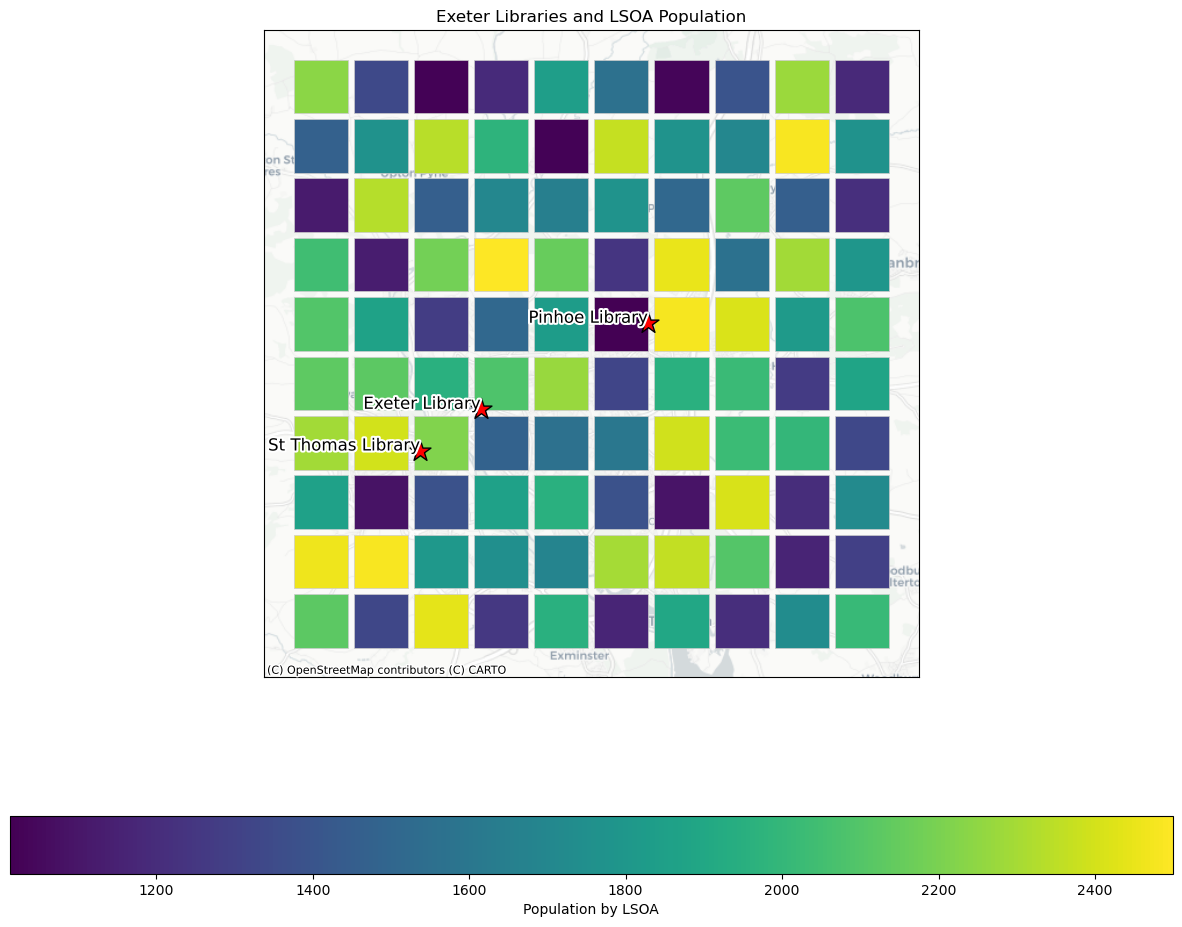

In [7]:
# Project to Web Mercator for plotting with contextily
lsoa_plot = lsoa_pop_gdf.to_crs(epsg=3857)
libraries_plot = libraries_with_demographics.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot LSOAs, colored by population (choropleth)
lsoa_plot.plot(column='population', cmap='viridis', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True,
               legend_kwds={'label': "Population by LSOA", 'orientation': "horizontal"})

# Plot the libraries
libraries_plot.plot(ax=ax, marker='*', color='red', markersize=250, edgecolor='black')

# Add labels for the libraries
for x, y, label in zip(libraries_plot.geometry.x, libraries_plot.geometry.y, libraries_plot.name):
    ax.text(x, y, label, fontsize=12, ha='right', path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground='white')])

ax.set_title('Exeter Libraries and LSOA Population')
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=12)

plt.show()

# Discussion:
# - The table and map clearly show how we've linked each library to its host LSOA and its corresponding population data.
# - This enriched data is the foundation for more advanced analysis. For example, you could now analyze if libraries are located in high-population areas, or join other datasets (like the Index of Multiple Deprivation) to assess if they serve areas of need.